<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preproccesing-Data" data-toc-modified-id="Preproccesing-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preproccesing Data</a></span><ul class="toc-item"><li><span><a href="#Scale-Information" data-toc-modified-id="Scale-Information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Scale Information</a></span></li><li><span><a href="#Split-Intro-Training-and-Test" data-toc-modified-id="Split-Intro-Training-and-Test-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Split Intro Training and Test</a></span></li></ul></li><li><span><a href="#NN:-Arquitecture-and-Training" data-toc-modified-id="NN:-Arquitecture-and-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NN: Arquitecture and Training</a></span><ul class="toc-item"><li><span><a href="#Plot-the-Predictions" data-toc-modified-id="Plot-the-Predictions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Plot the Predictions</a></span></li><li><span><a href="#Confidence-Bands" data-toc-modified-id="Confidence-Bands-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Confidence Bands</a></span></li></ul></li></ul></div>

# Confidence Intervals/Bands With Keras

In this notebook we construct not only prediction but confidence bands for a series problem using keras.

In [1]:
# Import the required libraries
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy
print(f'TF VERSION: {tf.__version__}')

TF VERSION: 2.4.1


## Preproccesing Data

In [2]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
# Fix random seed for reproducibility
numpy.random.seed(7)
# Load the dataset
dataframe = read_csv('../Data/ConfidenceBands/data.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

### Scale Information

In [4]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Split Intro Training and Test

In [5]:
# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## NN: Arquitecture and Training

In [7]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [8]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.17 RMSE
Test Score: 48.90 RMSE


### Plot the Predictions

In [9]:
# Shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [10]:
# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

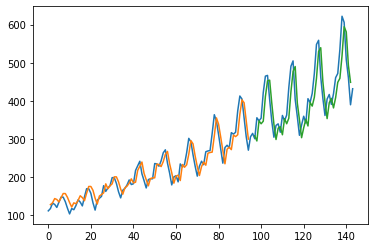

In [11]:
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:
# Predictions
predictions = list(trainPredict.reshape(trainPredict.shape[0],)) + \
              list(testPredict.reshape(testPredict.shape[0],))
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0],1)

### Confidence Bands

In [83]:
# For example for 90% confidence
ci = 0.99
lower_lim = np.quantile(predictions, 0.5-ci/2, axis=1)
upper_lim = np.quantile(predictions, 0.5+ci/2, axis=1)

lower_lim_p = numpy.empty_like(dataset)
lower_lim_p[:, :] = numpy.nan
lower_lim_p[1:141, :] = lower_lim.reshape(lower_lim.shape[0], 1)
upper_lim_p = numpy.empty_like(dataset)
upper_lim_p[:, :] = numpy.nan
upper_lim_p[1:141, :] = upper_lim.reshape(upper_lim.shape[0], 1)

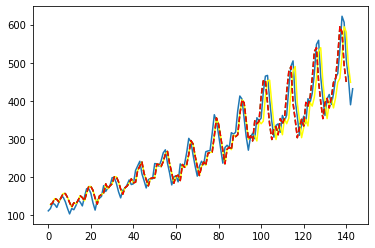

In [88]:
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color ='yellow')
plt.plot(testPredictPlot, color ='yellow')
plt.plot(lower_lim_p, linestyle='dashed', color='green')
plt.plot(upper_lim_p, linestyle='dashed', color='red')
plt.show()

Finally with the confidence bands fro our prediction!

# End